# Создание нейронной сети

В этом задании мы создадим полносвязную нейронную сеть используя при этом низкоуровневые механизмы tensorflow.

Архитектутра нейросети представлена на следующем рисунке. Как видите, в ней имеется один входной слой, два скрытых, а так же выходной слой. В качестве активационной функции в скрытых слоях будет использоваться сигмоида. На выходном слое мы используем softmax.

Часть кода по созданию сети уже написана, от вас требуется заполнить пропуски в указанных местах.

## Архитектура нейронной сети

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## О датасете MNIST

Данную нейросеть мы будем обучать на датасете MNIST. Этот датасет представляет собой большое количество изображений рукописных цифр размером $28 \times 28$ пикселей. Каждый пиксель принимает значение от 0 до 255.

Как и раньше датасет будет разеделен на обучающую и тестовую выборки. При этом мы выполним нормализацию всех изображений, чтобы значения пикселей находились в промежутке от 0 до 1, разделив яркость каждого пикселя на 255.

Кроме того, архитектура нейронной сети ожидает на вход вектор. В нашем же случае каждый объект выборки представляет собой матрицу. Что же делать? В этом задании мы "растянем" матрицу $28 \times 28$, получив при этом вектор, состоящей из 784 элементов.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Больше информации о датасете можно найти [здесь](http://yann.lecun.com/exdb/mnist/).

In [62]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.metrics import accuracy_score

In [2]:
num_classes = 10 # общее количество классов, в нашем случае это цифры от 0 до 9
num_features = 784 # количество атрибутов входного вектора 28 * 28 = 784

learning_rate = 0.001 # скорость обучения нейронной сети
training_steps = 3000 # максимальное число эпох
batch_size = 256 # пересчитывать веса сети мы будем не на всей выборке, а на ее случайном подможестве из batch_size элементов
display_step = 100 # каждые 100 итераций мы будем показывать текущее значение функции потерь и точности

n_hidden_1 = 128 # количество нейронов 1-го слоя
n_hidden_2 = 256 # количество нейронов 2-го слоя

In [3]:
from tensorflow.keras.datasets import mnist

# Загружаем датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

Here I want to show the first 10 images in the dataset and see the shapes

In [4]:
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [5]:
print(y_train.shape)
print(y_test.shape)

(60000,)
(10000,)


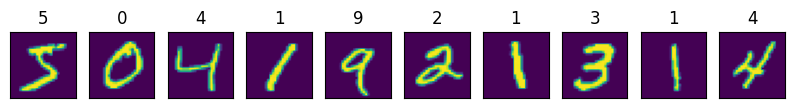

In [6]:
fig, axes = plt.subplots(ncols=10, sharex=False,
    sharey=True, figsize=(10, 4))
for i in range(10):
    axes[i].set_title(y_train[i])
    axes[i].imshow(x_train[i], cmap='viridis')
    axes[i].get_xaxis().set_visible(False)
    axes[i].get_yaxis().set_visible(False)
plt.show()

In [7]:
# Преобразуем целочисленные пиксели к типа float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Преобразуем матрицы размером 28x28 пикселей в вектор из 784 элементов
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормализуем значения пикселей
x_train, x_test = x_train / 255., x_test / 255.

# Перемешаем тренировочные данные
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [8]:
# Создадим нейронную сеть

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, out=0):
        y = tf.matmul(x, self.w) + self.b
        if out == 0:
          return tf.nn.sigmoid(y)
        else:
          return tf.nn.softmax(y)


class NN(tf.Module):

  def __init__(self, name=None):
    super().__init__(name=name)
    # Первый слой, состоящий из 128 нейронов
    self.layer_1 = DenseLayer(in_features=num_features, out_features=n_hidden_1)
    # Второй слой, состоящий из 256 нейронов
    self.layer_2 = DenseLayer(in_features=n_hidden_1, out_features=n_hidden_2)
    # Выходной слой
    self.layer_3 = DenseLayer(in_features=n_hidden_2, out_features=num_classes)


  def __call__(self, x):
    # Место для вашего кода
    # Помните что для выхода нейронной сети мы применяем к выходу функцию softmax.
    # Делаем мы это для того, чтобы
    # выход нейронной сети принимал значения от 0 до 1 в соответствии с вероятностью
    # принадлежности входного объекта к одному из 10 классов
    x1 = self.layer_1(x, out=0)
    x2 = self.layer_2(x1, out=0)
    x3 = self.layer_3(x2, out=1)
    return x3




In [9]:
# В качестве функции ошибки в данном случае удобно взять кросс-энтропию
def cross_entropy(y_pred, y_true):
    # Encode label to a one hot vector.
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Clip prediction values to avoid log(0) error.
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Вычисление кросс-энтропии
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# В качестве метрики качества используем точность
def accuracy(y_pred, y_true):
    corr_pred = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(corr_pred, tf.float32))

In [10]:
# Создадим экзампляр нейронной сети
neural_net = NN(name="mnist")

# Функция обучения нейросети
def train(nn, input_x, output_y):
  # Для подгонки весов сети будем использовать стохастический градиентный спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активация автоматического дифференцирования
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

    # Создадим оптимизируемых список параметров
    # Место для вашего кода
    trainable_variables = nn.trainable_variables

    # Вычислим по ним значение градиента
    # Место для вашего кода
    gradients = g.gradient(loss, trainable_variables)

    # Модифицируем параметры
    # Место для вашего кода
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [11]:
# Тренировка сети

loss_history = []  # каждые display_step шагов сохраняйте в этом список текущую ошибку нейросети
accuracy_history = [] # каждые display_step шагов сохраняйте в этом список текущую точность нейросети

# В этом цикле мы будем производить обучение нейронной сети
# из тренировочного датасета train_data извлеките случайное подмножество, на котором
# произведется тренировка. Используйте метод take, доступный для тренировочного датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps)):
    # Обновляем веса нейронной сети
    # Место для вашего кода
    train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        # Место для вашего кода
        current_loss = cross_entropy(pred, batch_y)
        current_accuracy = accuracy(pred, batch_y)

        accuracy_history.append(current_accuracy)
        loss_history.append(current_loss)
        print(f"Step: {step}, Loss: {current_loss}, Accuracy: {current_accuracy}")

Step: 0, Loss: 2805.313720703125, Accuracy: 0.08203125
Step: 100, Loss: 345.47454833984375, Accuracy: 0.671875
Step: 200, Loss: 233.86679077148438, Accuracy: 0.765625
Step: 300, Loss: 149.72518920898438, Accuracy: 0.83203125
Step: 400, Loss: 168.70654296875, Accuracy: 0.7890625
Step: 500, Loss: 130.97976684570312, Accuracy: 0.84765625
Step: 600, Loss: 187.00967407226562, Accuracy: 0.80078125
Step: 700, Loss: 79.69214630126953, Accuracy: 0.91796875
Step: 800, Loss: 98.14645385742188, Accuracy: 0.87890625
Step: 900, Loss: 128.56378173828125, Accuracy: 0.859375
Step: 1000, Loss: 112.04285430908203, Accuracy: 0.87890625
Step: 1100, Loss: 90.65415954589844, Accuracy: 0.8984375
Step: 1200, Loss: 85.61984252929688, Accuracy: 0.89453125
Step: 1300, Loss: 100.53038787841797, Accuracy: 0.890625
Step: 1400, Loss: 75.02186584472656, Accuracy: 0.921875
Step: 1500, Loss: 88.52044677734375, Accuracy: 0.87890625
Step: 1600, Loss: 72.9300765991211, Accuracy: 0.91015625
Step: 1700, Loss: 71.902709960937

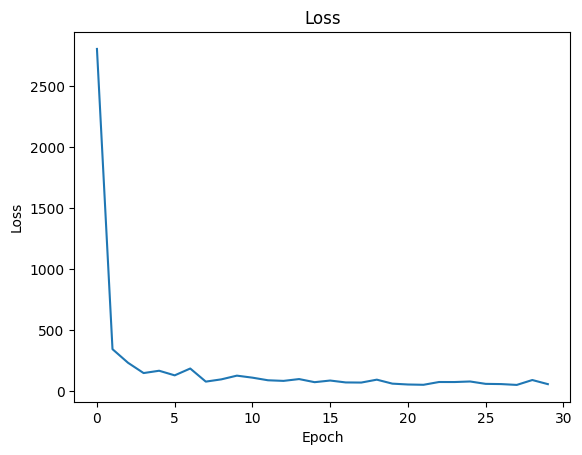

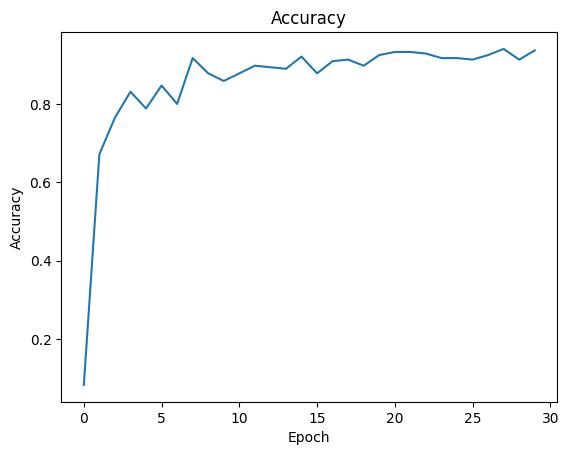

In [12]:
# Выведите графики зависимости изменения точности и потерь от шага
# Если все сделано правильно, то точность должна расти, а потери уменьшаться

plt.figure()
plt.plot(loss_history)
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

plt.figure()
plt.plot(accuracy_history)
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

In [80]:
# Вычислите точность обученной нейросети
predict = neural_net(x_test)
m = tf.keras.metrics.Accuracy()
m.update_state(y_test, tf.math.argmax(predict, axis=1))
m.result().numpy()

0.8983

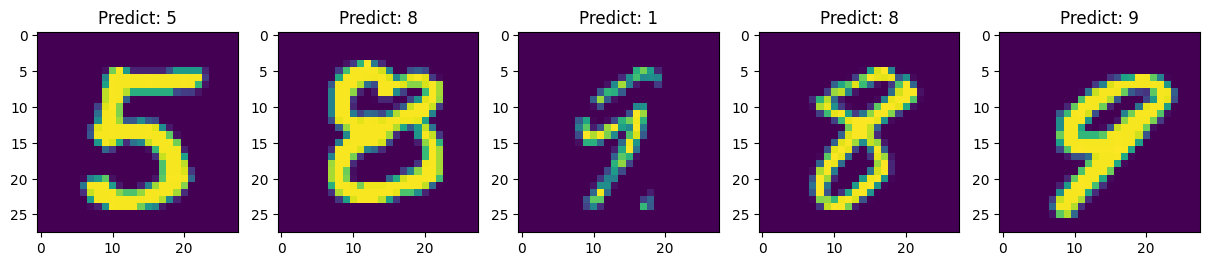

In [54]:
# Протестируем обученную нейросеть на 10 изображениях. Из тестовой выборки возьмите 5
# случайных изображений и передайте их в нейронню сеть.
# Выведите изображение и выпишите рядом ответ нейросети.
# Сделайте вывод о том ошибается ли ваша нейронная сеть и если да, то как часто?
images_count = 5
random_choice = random.sample(range(len(x_test)), images_count)
test_images = x_test[random_choice]
test_values = y_test[random_choice]

predict = neural_net(test_images)
predict_values = tf.argmax(predict, axis=1)

fig, ax = plt.subplots(1, 5)
fig.set_figheight(10)
fig.set_figwidth(15)
for i in range(len(test_images)):
    image = test_images[i].reshape((28, 28))
    value = test_values[i]
    predict_value = predict_values[i]
    ax[i].imshow(image, cmap='viridis')
    ax[i].set_title(f"Predict: {predict_value}")

